# Meta-population population flux library
## cv19mobility

In [3]:
%matplotlib tk

In [1]:

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
from cv19gm.utils import cv19mobility

In [29]:
population = [10000,15000,20000,30000]

In [30]:
mobility = cv19mobility.rnd_flux_symmetric(population = population,fraction=0.1)

In [31]:
mobility(0.2)

array([[   0,  366,  402,  231],
       [ 579,    0,  140,  779],
       [ 449,  318,    0, 1231],
       [2194,  137,  668,    0]])

In [34]:
mobility(0.7)

array([[   0,  579,  449, 2194],
       [ 366,    0,  318,  137],
       [ 402,  140,    0,  668],
       [ 231,  779, 1231,    0]])

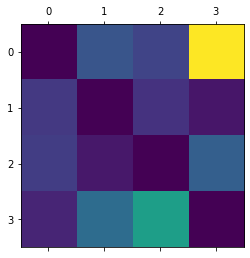

In [32]:
plt.matshow(mobility(0.5),)

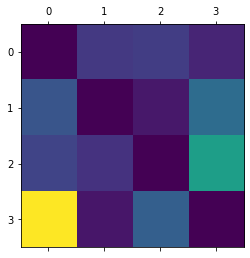

In [33]:
plt.matshow(mobility(0),)

In [27]:
a = cv19mobility.export_mobility(mobility)

In [28]:
a

'{"0.0": [[0, 781, 218], [689, 0, 810], [691, 1308, 0]], "0.5": [[0, 689, 691], [781, 0, 1308], [218, 810, 0]], "1.0": [[0, 781, 218], [689, 0, 810], [691, 1308, 0]], "1.5": [[0, 689, 691], [781, 0, 1308], [218, 810, 0]]}'

In [44]:
def import_mobility(input=None,path=None,fill='periodic'):
    """Create mobility matrix from data

    Args:
        input (dic): Create Use a numpy array or a list as a base
        path (_type_, optional): Path to json file. Defaults to None.
        fill (str, optional): Mechanism for completing the matrix after. Defaults to 'periodic'.

    Returns:
        _type_: _description_
    """
    aux = {}
    if not t:
        t = np.arange(0,2,0.5)
    for i in t:
        aux[i] = mobfunction(i).tolist()
    if path:
        json.dump(aux,path)
    return json.dumps(aux)

TypeError: Object of type ndarray is not JSON serializable

In [9]:
from numpy import linspace
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [17]:
from numpy import linspace
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection = '3d')


In [19]:
from numpy import linspace
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import signal

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')


t = np.linspace(0, 1, 1000, endpoint=True)
ax.plot3D(t, signal.square(2 * np.pi * 5 * t))


In [20]:
from numpy import linspace
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import signal

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

t = np.linspace(0, 1, 1000, endpoint=True)
ax.plot3D(t, signal.square(2 * np.pi * 5 * t))

for angle in range(0, 360):
    ax.view_init(angle,30)
    plt.draw()
    plt.pause(.001)


KeyboardInterrupt: 

In [8]:
from numpy import linspace
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import signal

# Creating 3D figure
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')

# Creating Dataset
t = np.linspace(0, 1, 1000, endpoint = True)
ax.plot3D(t, signal.square(2 * np.pi * 5 * t))

# 360 Degree view
for angle in range(0, 360):
    ax.view_init(angle, 30)
    plt.draw()
    plt.pause(.001)
	
plt.show()


KeyboardInterrupt: 

-------

In [4]:
from cv19gm.utils import cv19mobility

In [5]:
population = [10000,15000,20000,30000]
mobility = cv19mobility.rnd_flux_symmetric(population = population,fraction=0.1)

In [6]:
mob_matrix = cv19mobility.mobility_to_tensor(mobility,100)

In [8]:
np.shape(mob_matrix)

(200, 4, 4)

In [23]:
len(mob_matrix)

200

In [21]:

int(2*1.5)

3